# 1. Install Dependencies and Setup

In [1]:
print("Hello, world!")

Hello, world!


!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib

In [2]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      2.0.0
anyio                        4.2.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.14.0
beautifulsoup4               4.12.2
bleach                       6.1.0
cachetools                   5.3.2
certifi                      2023.11.17
cffi                         1.16.0
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.0
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.0
executing                    2.0.1
fastjsonschema             


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


!pip install --force-reinstall protobuf==3.20.0

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [14]:
tf.keras.utils.image_dataset_from_directory??

In [15]:
data = tf.keras.utils.image_dataset_from_directory('data', image_size=(512, 512))

Found 305 files belonging to 2 classes.


In [16]:
data_iterator = data.as_numpy_iterator()

In [17]:
batch = data_iterator.next()

In [18]:
batch[0].shape

(32, 512, 512, 3)

In [19]:
batch[1]

array([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1])

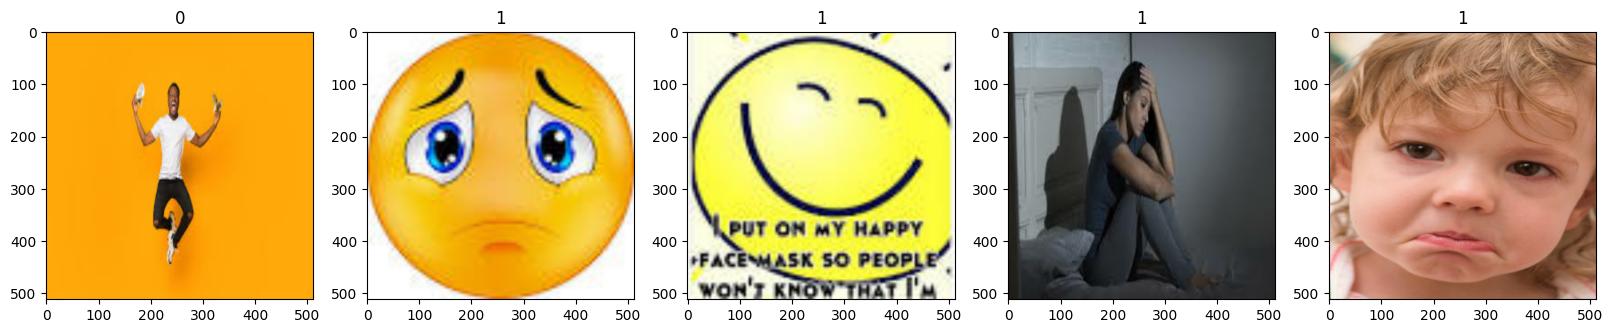

In [20]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [21]:
data = data.map(lambda x,y: (x/512, y))

In [29]:
new_batch = data.as_numpy_iterator().next()

In [30]:
new_batch

(array([[[[0.12890625, 0.18359375, 0.0390625 ],
          [0.13021088, 0.18228912, 0.0390625 ],
          [0.12846375, 0.179245  , 0.03666687],
          ...,
          [0.45552063, 0.47354126, 0.31946564],
          [0.45572662, 0.47330475, 0.31510162],
          [0.4585495 , 0.47612762, 0.3179245 ]],
 
         [[0.12890625, 0.18359375, 0.0390625 ],
          [0.12942225, 0.1815005 , 0.03827386],
          [0.12741685, 0.1781981 , 0.03561997],
          ...,
          [0.45447373, 0.47249436, 0.31659243],
          [0.45454597, 0.4721241 , 0.31155968],
          [0.4564511 , 0.4740292 , 0.3134648 ]],
 
         [[0.12890625, 0.18359375, 0.0390625 ],
          [0.12890625, 0.1809845 , 0.03775787],
          [0.12665647, 0.17743772, 0.03485959],
          ...,
          [0.45378876, 0.4718094 , 0.31471252],
          [0.4537735 , 0.4720173 , 0.30791092],
          [0.45507812, 0.4733219 , 0.30921555]],
 
         ...,
 
         [[0.266852  , 0.33325824, 0.21607074],
          [0.26502

In [35]:
new_batch[0].max()

0.49804688

# 5. Split Data

In [36]:
len(data)

10

In [39]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [40]:
train_size

7

In [41]:
val_size

2

In [42]:
test_size

1

In [43]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [45]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [47]:
model = Sequential()

In [48]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(512,512,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [49]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 16)      4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 16)       0

# 7. Train

In [51]:
logdir='logs'

In [52]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [53]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 13s 239ms/step - loss: 1.0994 - accuracy: 0.5268 - val_loss: 0.6758 - val_accuracy: 0.5625
Epoch 2/20
7/7 [==============================] - 2s 219ms/step - loss: 0.6633 - accuracy: 0.5670 - val_loss: 0.6032 - val_accuracy: 0.8281
Epoch 3/20
7/7 [==============================] - 2s 202ms/step - loss: 0.5293 - accuracy: 0.7946 - val_loss: 0.4584 - val_accuracy: 0.7812
Epoch 4/20
7/7 [==============================] - 2s 203ms/step - loss: 0.4037 - accuracy: 0.8438 - val_loss: 0.2848 - val_accuracy: 0.9219
Epoch 5/20
7/7 [==============================] - 2s 214ms/step - loss: 0.2556 - accuracy: 0.9241 - val_loss: 0.1651 - val_accuracy: 0.9531
Epoch 6/20
7/7 [==============================] - 2s 207ms/step - loss: 0.1761 - accuracy: 0.9464 - val_loss: 0.0973 - val_accuracy: 0.9688
Epoch 7/20
7/7 [==============================] - 2s 205ms/step - loss: 0.1542 - accuracy: 0.9464 - val_loss: 0.0597 - val_accuracy: 0.9844
Epoch 8/20
7/7 [===

# 8. Plot Performance

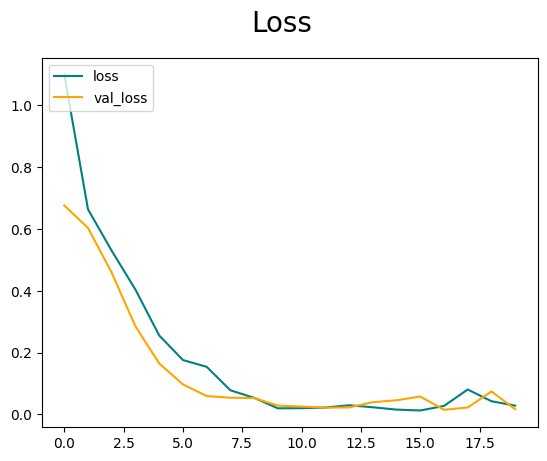

In [54]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

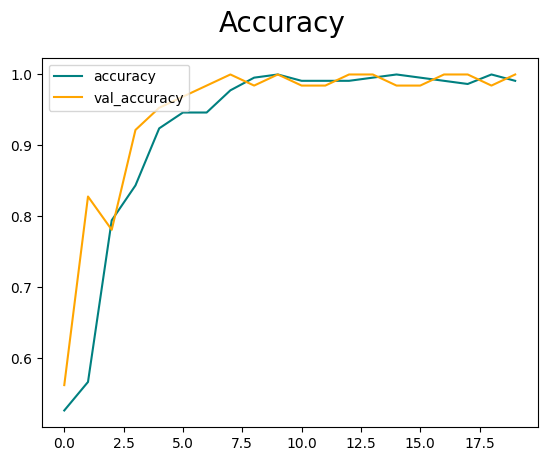

In [55]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [56]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [57]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [58]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [59]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

import cv2

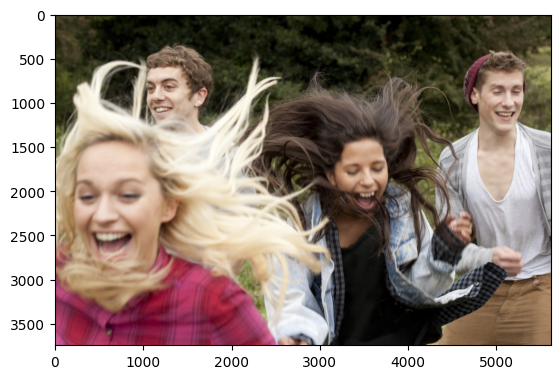

In [61]:
img = cv2.imread('happytest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

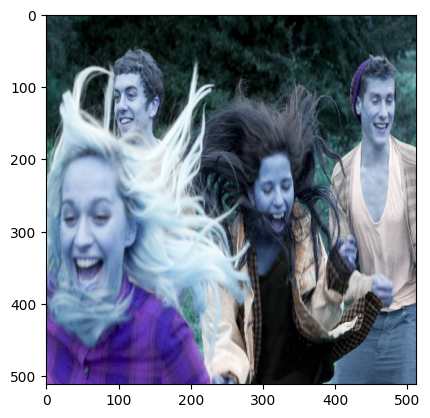

In [63]:
resize = tf.image.resize(img, (512,512))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [64]:
yhat = model.predict(np.expand_dims(resize/512, 0))

In [65]:
yhat

array([[0.00127861]], dtype=float32)

In [66]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model(os.path.join('models', 'imageclassifier.h5'))

In [ ]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhatnew